# Multi-Label Text Classification: DBpedia Ontology Classes

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz) was acquired from Fastai. It's a subset from the [DBpedia set](https://wiki.dbpedia.org/data-set-2014) and contains 40,000 training samples and 5,000 testing samples from 14 nonoverlapping classes from DBpedia 2014.

The DBpedia project extracts structured information from Wikipedia editions and combines this information into a cross-domain knowledge base.

The 14 classes in this set are:
- Company
- Educational Institution
- Artist
- Athlete
- Office Holder
- Mean Of Transportation
- Building
- Natural Place
- Village
- Animal
- Plant
- Album
- Film
- Written Work

The data downloaded contains a training set and a test set. The goal of this model is to see if we can predict the correct class based on typing a few sentences. We will use the sentence in the test set to make our predictions.


The data was downloaded, zipped and then uploaded to the Google Cloud Platform, which is used to train the model.

First we unzip the files.

In [10]:
import zipfile
zip_ref = zipfile.ZipFile('Data/dbpedia.zip', 'r')
zip_ref.extractall('Data/')
zip_ref.close()

In [5]:
# Defining the path where the files are kept
path = Path('Data/dbpedia')

In [4]:
path.ls()

[PosixPath('Data/dbpedia/models'),
 PosixPath('Data/dbpedia/tmp'),
 PosixPath('Data/dbpedia/test.csv'),
 PosixPath('Data/dbpedia/classes.txt'),
 PosixPath('Data/dbpedia/train.csv'),
 PosixPath('Data/dbpedia/readme.txt')]

Let's have a look at the training set data

In [6]:
df = pd.read_csv(path/'train.csv', header = -1)
df.head(10)

,0,1,2
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...
5,1,The Unsigned Guide,The Unsigned Guide is an online contacts dire...
6,1,Rest of the world,Within sports and games played at the interna...
7,1,Globoforce,Globoforce is a multinational company co-head...
8,1,Rompetrol,The Rompetrol Group N.V. is a Romanian oil co...
9,1,Wave Accounting,Wave is the brand name for a suite of online ...


In [17]:
df[1][5]

'The Unsigned Guide'

It contains one line per class, with the labels 1 through 14 for each class and the text

In [5]:
# doc(TextClasDataBunch)

We create a fastai [Databunch](https://docs.fast.ai/basic_data.html) to get the data ready for training.

In [10]:
data_cl = TextClasDataBunch.from_csv(path, 'train.csv') 

Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextClasDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [45]:
data_cl.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
#data = TextDataBunch.load(path)

In [8]:
(path/'tmp').ls()

[PosixPath('Data/dbpedia/tmp/train_lbl.npy'),
 PosixPath('Data/dbpedia/tmp/valid_ids.npy'),
 PosixPath('Data/dbpedia/tmp/classes.txt'),
 PosixPath('Data/dbpedia/tmp/test_ids.npy'),
 PosixPath('Data/dbpedia/tmp/valid_lbl.npy'),
 PosixPath('Data/dbpedia/tmp/itos.pkl'),
 PosixPath('Data/dbpedia/tmp/train_ids.npy')]

The path folder contains a tmp folder with the valid, train, and labels data organized as Numpy arrays.

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [14]:
data_cl.show_batch()

text,target
xxbos xxfld 1 xxmaj this xxmaj is xxmaj it and i xxmaj am xxmaj it and xxmaj you xxmaj are xxmaj it and xxmaj so xxmaj is xxmaj that and xxmaj he xxmaj is xxmaj it and xxmaj she xxmaj is xxmaj it and xxmaj it xxmaj is xxmaj it and xxmaj that xxmaj is xxmaj that,12
xxbos xxfld 1 xxmaj wrought - iron cross sites of xxmaj st. xxmaj john 's xxmaj cemetery ( xxmaj zeeland xxmaj north xxmaj dakota ),7
xxbos xxfld 1 xxmaj the xxmaj rose in xxmaj splendour : a xxmaj story of the xxmaj wars of xxmaj lancaster and xxmaj york,14
xxbos xxfld 1 xxmaj not xxmaj quite xxmaj hollywood : xxmaj the xxmaj wild xxmaj untold xxmaj story of xxmaj xxunk !,13
xxbos xxfld 1 xxmaj south of the xxmaj border ( xxmaj herb xxmaj alpert 's xxmaj tijuana xxmaj brass album ),12


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear on the list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [15]:
data_cl.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '1',
 ')']

The training set and the validation set were split by the default 80%/ 20%

In [22]:
data_cl.train_ds

LabelList
y: CategoryList (447999 items)
[Category 10, Category 14, Category 4, Category 12, Category 12]...
Path: Data/dbpedia
x: TextList (447999 items)
[Text xxbos xxfld 1 xxmaj purple - throated xxmaj xxunk, Text xxbos xxfld 1 xxmaj the xxmaj golden xxmaj gate ( xxmaj vikram xxmaj seth novel ), Text xxbos xxfld 1 xxmaj david xxmaj xxunk, Text xxbos xxfld 1 xxmaj halfway xxmaj tree, Text xxbos xxfld 1 xxmaj tales of xxmaj xxunk]...
Path: Data/dbpedia

In [20]:
data_cl.valid_ds

LabelList
y: CategoryList (112000 items)
[Category 10, Category 12, Category 8, Category 13, Category 14]...
Path: Data/dbpedia
x: TextList (112000 items)
[Text xxbos xxfld 1 xxmaj xxunk xxunk, Text xxbos xxfld 1 xxmaj godspeed ( xxmaj vincent album ), Text xxbos xxfld 1 xxmaj xxunk xxmaj river, Text xxbos xxfld 1 xxmaj xxunk ( film ), Text xxbos xxfld 1 xxmaj the xxmaj book of xxmaj earth]...
Path: Data/dbpedia

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [32]:
data_cl.train_ds[50][0] # For example, xxfld is a separate field of the document 
# and xxcap is when a token is in all caps and it gets lowered cased

Text xxbos xxfld 1 xxmaj chevrolet xxmaj spark

In [34]:
data_cl.train_ds[50] # This tokenized text belongs to category 6

(Text xxbos xxfld 1 xxmaj chevrolet xxmaj spark, Category 6)

But the underlying data is all numbers. Every number represents a text token.

In [39]:
data_cl.train_ds[50][0].data[:]

array([   2,    3,    8,    4, 1359,    4, 6546])

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

We can then create a model to classify those reviews.

In [45]:
learn = text_classifier_learner(data_cl, drop_mult=0.5)
# drop_multi is dropout regularization. You can reduce the number to avoid underfitting like 0.01.

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


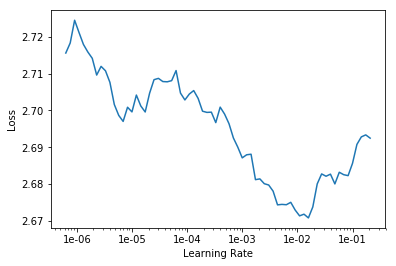

In [53]:
learn.recorder.plot(skip_end=15)
# Skip_end omits the end part of the graph so that it’s easier to see the earlier part of the graph.
# It tells plotter to skip the last 3 values for the curve.

In [55]:
learn.fit_one_cycle(1, 3e-3, moms=(0.8,0.7)) 
# We choose the cuve at the steepes point, which is around 3e-3.
# moms adds momentum to the weights to improve the training speed and leads to better convergence

epoch,train_loss,valid_loss,accuracy
1,0.907840,0.851973,0.702750


Training one cycle took 5:32 on a V100 GPU machine

In [56]:
# We save our first model
learn.save('dbpedia-first')

In [58]:
learn.load('dbpedia-first');

In [ ]:
learn.unfreeze # We unfreeze the layers in the model and train it again for more epochs

In [59]:
learn.fit_one_cycle(4, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.901743,0.866632,0.692857
2,0.789243,0.826172,0.709188
3,0.801785,0.789800,0.715813
4,0.636724,0.770878,0.719741


In [60]:
learn.save('dbpedia-unfreezed')

In [65]:
learn.load('dbpedia-unfreezed');

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


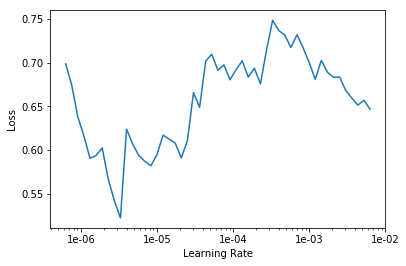

In [67]:
learn.recorder.plot(skip_end=15)

In [68]:
learn.freeze_to(-2) # This unfreezes that last 2layers
learn.fit_one_cycle(1, slice(1e-7/(2.6**4),3e-6), moms=(0.8,0.7))
# For NLP RNN's 2.6 is a good number to use to decrease the learning rate from layer to layer.
# Many models were run and 2.6 was the optimal parameter for the lr. 

epoch,train_loss,valid_loss,accuracy
1,0.703237,0.774666,0.719232


In [69]:
learn.save('dbpedia-second')

In [70]:
learn.load('dbpedia-second');

In [71]:
learn.unfreeze()# This unfreezes every layer
learn.fit_one_cycle(2, slice(1e-7/(2.6**4),3e-6), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.680084,0.770684,0.720500
2,0.635730,0.774234,0.719580


After training 2 epcohs the model accuracy is 72% against the validation set. Let's see how the model predicts a sentence. We will use a sentence from the test dataset found inside test.csv.

In [75]:
learn.predict("Zapoteca portoricensis subsp. portoricensis is a perennial tree.")

(Category 11,
 tensor(10),
 tensor([2.3136e-09, 3.4432e-13, 5.5036e-12, 1.3816e-12, 1.1250e-13, 4.8899e-11,
         2.5496e-12, 2.6648e-06, 1.9776e-05, 2.9191e-06, 9.9997e-01, 7.0180e-09,
         1.1306e-09, 3.7894e-10]))

The model is predicting Category 11, which is the plant category. Here are the categories:

- Company
- Educational Institution
- Artist
- Athlete
- Office Holder
- Mean Of Transportation
- Building
- Natural Place
- Village
- Animal
- Plant
- Album
- Film
- Written Work

In this case the model is correct, but in many cases, the model misses.  Taking a look at the confussion matrix will help us see how well the model does across categories.

In [78]:
data_cl.classes

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
from fastai.vision import *
interp = ClassificationInterpretation.from_learner(learn)

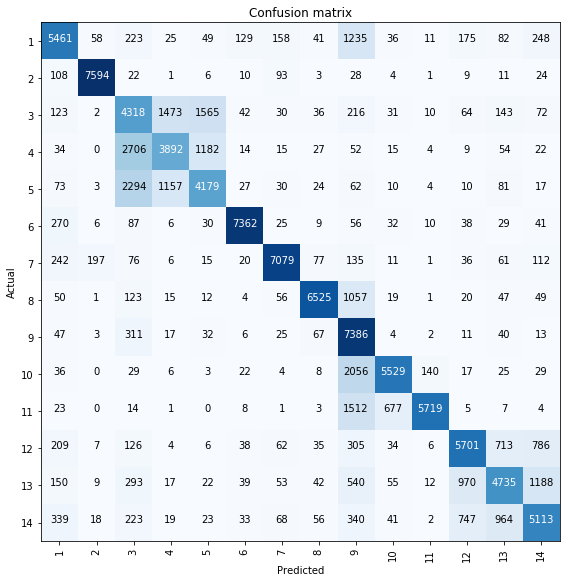

In [77]:
interp.plot_confusion_matrix(figsize=(8,8))

From the confusion matrix one can see that the model has the most diffuclty differentiating the text between classes 3, 4, and 5, which are the Artist, Athlete, and Office holder. It also has difficulty distinguishing the text between the classes 9 and 10, which are Village and Animal.

The algorithm performs best when distingusing between Educataion Institution and Natural Place